# Visor NDVI

This notebook loads each city's NDVI data, filters for urban hexs (if required), categorizes NDVI and calculates slope and creates the .html needed for kepler visualization.

* Worked fine with keplergl v0.3.2, but not with kepler v.0.3.7.

## Import libraries

In [1]:
from pathlib import Path

current_path = Path().resolve()

for parent in current_path.parents:
    if parent.name == "accesibilidad-urbana":
        project_root = parent
        break

print(project_root)

/home/jovyan/accesibilidad-urbana


In [2]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt

# Imports que venían en el Notebook 15-min-city > 13-15-min-kepler-test.ipynb
import io
#import boto3
from keplergl import KeplerGl

# Add slope to config dict.
import copy

# Correlation calc
import scipy.stats as stats

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join(project_root))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

## Config notebook

In [11]:
test = False
if test == True:
    city_lst = ['Monterrey'] # Gets overwritten if test = False
    res = 10
else:
    res = 10
    
projected_crs = 'EPSG:6372'
# Filter for urban areas only?
filter_urban = True
# Directory where .html files are saved
map_output_dir = str(project_root) + f"/data/processed/visor_ndvi/"

In [4]:
# Slope function
def calc_slope(row, cols):
    data = row[cols].astype(float).values
    slope, intercept = np.polyfit(years, data, 1)
    return slope

## Find all available cities (If test = False, rewrites city_list)

In [15]:
if test == False:
    # Find all available cities
    ndvi_schema = 'raster_analysis'
    ndvi_table = 'ndvi_analysis_hex'
    scan_res = 8
    query = f"SELECT city FROM {ndvi_schema}.{ndvi_table} WHERE \"res\" = '{scan_res}\'"
    ndvi_df = aup.df_from_query(query)
    city_lst = list(ndvi_df.city.unique())

print(f"Cities to run: {len(city_lst)}.")
city_lst

Cities to run: 49.


['Acapulco',
 'Aguascalientes',
 'CDMX',
 'Chihuahua',
 'Chilpancingo',
 'Ciudad Obregon',
 'Colima',
 'Cuautla',
 'Cuernavaca',
 'Delicias',
 'Durango',
 'Ensenada',
 'Guadalajara',
 'Hermosillo',
 'Juarez',
 'Laguna',
 'La Paz',
 'Los Cabos',
 'Los Mochis',
 'Matamoros',
 'Mazatlan',
 'Mexicali',
 'Monclova',
 'Monterrey',
 'Nogales',
 'Nuevo Laredo',
 'Oaxaca',
 'Pachuca',
 'Piedras Negras',
 'Poza Rica',
 'Puebla',
 'Queretaro',
 'Reynosa',
 'San Martin',
 'Tapachula',
 'Tehuacan',
 'Tepic',
 'Tijuana',
 'Tlaxcala',
 'Toluca',
 'Tulancingo',
 'Uruapan',
 'Vallarta',
 'Victoria',
 'Villahermosa',
 'Xalapa',
 'Zacatecas',
 'Zamora',
 'ZMVM']

## Create Kepler HTMLs files by city

In [10]:
i=0
for city in city_lst:

    try:
        print(f"--- STARTING CITY {i}/{len(city_lst)}: {city}.")
    
        # 1.0 --- --- --- LOAD DATA --- --- ---
        
        # 1.1 --- LOAD URBAN HEXS
        print(f"Loading {city}'s urban hexs.")
        # Load data
        hex_schema = 'hexgrid'
        hex_table = f'hexgrid_{res}_city_2020'
        # Filter for urban areas if required
        if filter_urban:
            hex_type = 'urban'
            query = f"SELECT hex_id_{res}, geometry FROM {hex_schema}.{hex_table} WHERE \"city\" = '{city}\' AND \"type\" = '{hex_type}\'"
        else:
            query = f"SELECT hex_id_{res}, geometry FROM {hex_schema}.{hex_table} WHERE \"city\" = '{city}\'"
        # Read and format cols
        hex_gdf = aup.gdf_from_query(query, geometry_col='geometry')
        hex_gdf['res'] = res
        hex_gdf.rename(columns={f'hex_id_{res}':'hex_id'},inplace=True)
        hex_gdf.to_crs(projected_crs,inplace=True)
        # List all unique hex_ids
        hexid_lst = list(hex_gdf.hex_id.unique())
        
        # 1.2 --- LOAD NDVI DATA
        print(f"Loading {city}'s NDVI data.")
        ndvi_schema = 'raster_analysis'
        ndvi_table = 'ndvi_analysis_hex'
        query = f"SELECT * FROM {ndvi_schema}.{ndvi_table} WHERE \"city\" = '{city}\' AND \"res\" = '{res}\'"
        ndvi_gdf = aup.gdf_from_query(query, geometry_col='geometry')
        ndvi_gdf.to_crs(projected_crs,inplace=True)
        # Filter for urban areas if required
        if filter_urban:
            ndvi_gdf = ndvi_gdf.loc[ndvi_gdf.hex_id.isin(hexid_lst)].copy()
        # Inf values check
        infs = ndvi_gdf.loc[np.isinf(ndvi_gdf['ndvi_mean'])]
        if len(infs)>0:
            print(f"WARNING: Dropping {len(infs)} hexs res {res} because of inf values.")
            ndvi_gdf = ndvi_gdf.loc[~np.isinf(ndvi_gdf['ndvi_mean'])].copy()
    
        
        # 2.0 --- --- --- CALCULATIONS --- --- ---
        
        # 2.1 --- CALCULATE NDVI SLOPE
        print(f"Calculating {city}'s NDVI slope.")
        years = np.array([2018, 2019, 2020, 2021, 2022, 2023])
        # --- --- --- Calculate slopes
        ndvi_columns = [f'ndvi_{year}' for year in years]
        ndvi_gdf['ndvi_slope'] = ndvi_gdf.apply(calc_slope, args=(ndvi_columns,), axis=1)
    
        # 2.2 --- CALCULATE NDVI CATEGORIES
        # Create vegetation categories
        ndvi_gdf['ndvi_median_rango'] = np.nan
        ndvi_gdf.loc[ndvi_gdf.ndvi_median>=0.6 , 'ndvi_median_rango'] = 'Alta densidad vegetal'
        ndvi_gdf.loc[(ndvi_gdf.ndvi_median>=0.4 )&
                     (ndvi_gdf.ndvi_median<0.6), 'ndvi_median_rango'] = 'Moderada densidad vegetal'
        ndvi_gdf.loc[(ndvi_gdf.ndvi_median>=0.2)&
                     (ndvi_gdf.ndvi_median<0.4), 'ndvi_median_rango'] = 'Mínima densidad vegetal'
        ndvi_gdf.loc[(ndvi_gdf.ndvi_median>=0.1)&
                     (ndvi_gdf.ndvi_median<0.2), 'ndvi_median_rango'] = 'Suelo'
        ndvi_gdf.loc[(ndvi_gdf.ndvi_median<0.1), 'ndvi_median_rango'] = 'Suelo artificial/Agua/Piedra'
    
        #Definir orden y convertir pct_inf_rango en categoría ordenada
        categories = ['Suelo artificial/Agua/Piedra', 'Suelo', 'Mínima densidad vegetal', 'Moderada densidad vegetal', 'Alta densidad vegetal']
        ndvi_gdf['ndvi_median_rango'] = pd.Categorical(ndvi_gdf['ndvi_median_rango'], categories=categories, ordered=True)
    
        # 3.0 --- --- --- DATA TREATMENT --- --- ---
        # Rename columns of interest
        main_col = 'Rango de vegetación'
        slope_col = 'Cambio 2018 a 2023'
        rename_columns = {'ndvi_median_rango':main_col,
                          'ndvi_slope':slope_col}
        hex_kepler = ndvi_gdf.copy()
        hex_kepler.rename(columns=rename_columns,inplace=True)
        # Keep columns of interest and geometry
        hex_kepler = hex_kepler[[main_col,slope_col,'geometry']]
    
        # 4.0 --- --- --- KEPLER CONFIGURATION --- --- ---
        # Append dummy rows to gdf (They don't show since nothing is assigned to 'geometry' col,
        # but ensures that all categories are present in each city (And therefore, the simbology doesn't vary from city to city)
        dummy_rows = pd.DataFrame({main_col: ['Suelo artificial/Agua/Piedra', 'Suelo', 'Mínima densidad vegetal', 'Moderada densidad vegetal', 'Alta densidad vegetal'],
                                   slope_col: [None]*5})
        dummy_gdf = gpd.GeoDataFrame(dummy_rows, geometry=[None]*5, crs=hex_kepler.crs)
        hex_kepler_complete = pd.concat([hex_kepler, dummy_gdf], ignore_index=True)
        
        # Kepler not loading if it is projected_crs
        if hex_kepler_complete.crs != "EPSG:4326":
            hex_kepler_complete.to_crs("EPSG:4326",inplace=True)
            print(f"Changed {city}'s hex_kepler_complete crs to EPSG:4326.")
        
        # CONFIGURATION
        config, config_idx = aup.kepler_config()
        # CONFIGURATION - Configure visualized layer
        config["config"]["visState"]["layers"][0]["visualChannels"]["colorField"]["name"] = main_col
        
        # CONFIGURATION - Configure the color palette of the visualized layer
        # BRBG color palette divided in 5 categories (Vegetation). Browns for lower values, Greens for higher values.
        brbg_5 = ["#01665E", #Dark green-blueish
                  "#35978F", #Light green-blueish
                  "#DFE6E1", #Light gray
                  "#BF812D", #Light brown
                  "#8C510A"] #Dark brown
        config["config"]["visState"]["layers"][0]["config"]["visConfig"]["colorRange"] = {
            "name": "BrBG_custom",
            "type": "custom",
            "category": "Custom",
            "colors": brbg_5,
            "reversed": False
        }
        # CONFIGURATION - Stroke width
        config["config"]["visState"]["layers"][0]["config"]["visConfig"]["thickness"] = 0
        # CONFIGURATION - Opacity
        config["config"]["visState"]["layers"][0]["config"]["visConfig"]["opacity"] = 0.1

        # CONFIGURATION - Turn on geocoder (Search tab)
        config["config"]["visState"]["interactionConfig"]["geocoder"]["enabled"] = True
        
        # CONFIGURATION - Configure map starting point
        longitude = hex_kepler_complete.dissolve().geometry.centroid.x
        latitude = hex_kepler_complete.dissolve().geometry.centroid.y
        config["config"]["mapState"]["latitude"] = latitude[0]
        config["config"]["mapState"]["longitude"] = longitude[0]
        
        # CONFIGURATION - Configure data when hovering over hex
        # Just one layer
        #config["config"]["visState"]["interactionConfig"]["tooltip"]["fieldsToShow"]["Análisis de hexágono"] = [main_col,slope_col]
        # Two layers
        config["config"]["visState"]["interactionConfig"]["tooltip"]["fieldsToShow"] = {
            "Análisis de hexágono": [main_col],
            "Análisis de pendiente": [slope_col]
        }
        
        # ADD CONFIGURATION AND DATA TO MAP
        map_city = KeplerGl(height=800)
        map_city.config = config
        map_city.add_data(hex_kepler_complete, name='Análisis de hexágono')
    
        print(f"Finished {city}'s map config.")
    
        # 4.0 --- --- --- SAVE HTML --- --- ---
        map_city.save_to_html(file_name = map_output_dir+f"ndvi_{city}_res{res}.html", read_only=False)

    except:
        print("--"*30)
        print(f"ERROR: {city}.")
        print("--"*30)

    i+=1

--- STARTING CITY 0/1: Monterrey.
Loading Monterrey's urban hexs.
Loading Monterrey's NDVI data.
Calculating Monterrey's NDVI slope.
Changed Monterrey's hex_kepler_complete crs to EPSG:4326.


/tmp/ipykernel_21764/1269612333.py:122: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_21764/1269612333.py:123: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/opt/conda/envs/gds/lib/python3.9/site-packages/jupyter_client/session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


Finished Monterrey's map config.
Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/ndvi_Monterrey_res10.html!


## Pruebas Keplerg

<Axes: >

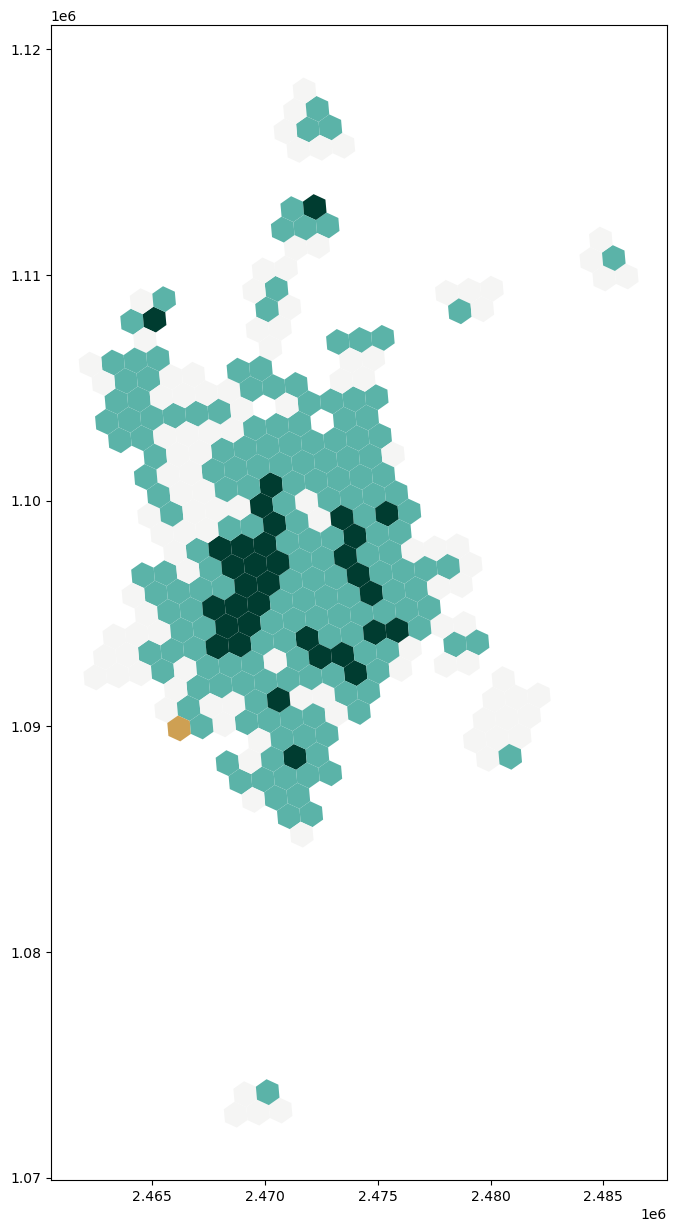

In [11]:
fig,ax = plt.subplots(figsize=(15,15))
hex_kepler.plot('Rango de vegetación',ax=ax,cmap='BrBG_r')

In [34]:
# 4.0 --- --- --- KEPLER CONFIGURATION --- --- ---
# Append dummy rows to gdf (They don't show since nothing is assigned to 'geometry' col,
# but ensures that all categories are present in each city (And therefore, the simbology doesn't vary from city to city)
dummy_rows = pd.DataFrame({main_col: ['Suelo artificial/Agua/Piedra', 'Suelo', 'Mínima densidad vegetal', 'Moderada densidad vegetal', 'Alta densidad vegetal'],
                           slope_col: [None]*5})
dummy_gdf = gpd.GeoDataFrame(dummy_rows, geometry=[None]*5, crs=hex_kepler.crs)
hex_kepler_complete = pd.concat([hex_kepler, dummy_gdf], ignore_index=True)

# Kepler not loading if it is projected_crs
if hex_kepler_complete.crs != "EPSG:4326":
    hex_kepler_complete.to_crs("EPSG:4326",inplace=True)
    print(f"Changed hex_kepler_complete crs to EPSG:4326.")

# CONFIGURATION
config, config_idx = aup.kepler_config()

# CONFIGURATION - Configure visualized layer
config["config"]["visState"]["layers"][0]["visualChannels"]["colorField"]["name"] = main_col

# CONFIGURATION - Configure the color palette of the visualized layer
# BRBG color palette divided in 5 categories (Vegetation). Browns for lower values, Greens for higher values.
brbg_5 = ["#01665E", #Dark green-blueish
          "#35978F", #Light green-blueish
          "#DFE6E1", #Light gray
          "#BF812D", #Light brown
          "#8C510A"] #Dark brown

config["config"]["visState"]["layers"][0]["config"]["visConfig"]["colorRange"] = {
    "name": "BrBG_custom",
    "type": "custom",
    "category": "Custom",
    "colors": brbg_5,
    "reversed": False
}

# CONFIGURATION - Configure ??
#config["config"]["visState"]["interactionConfig"]["tooltip"]["fieldsToShow"][
#    "datos"]= [final_max_column, 'max_escuelas', 'pobtot']
# hex_gdf["d"] = 0

# CONFIGURATION - Configure map starting point
longitude = hex_kepler_complete.dissolve().geometry.centroid.x
latitude = hex_kepler_complete.dissolve().geometry.centroid.y
config["config"]["mapState"]["latitude"] = latitude[0]
config["config"]["mapState"]["longitude"] = longitude[0]

# CONFIGURATION - Configure ??
# session = boto3.Session(profile_name="observatorio")
# dev_s3_client = session.client("s3")
# map_city = KeplerGl(height=800, data={"Análisis de ciudad": hex_kepler}, config=config_idx)

no_agregar_pendiente = """
# CONFIGURATION - Second layer (Slope) configuration [ANÁLISIS DE PENDIENTE]
# Duplicate previous configuration
slope_layer = copy.deepcopy(config["config"]["visState"]["layers"][0])
# Set new ID and label
slope_layer["id"] = "slope_layer"
slope_layer["config"]["label"] = "Pendiente de vegetación"
slope_layer["config"]["dataId"] = "Análisis de pendiente"
# Configure chanels (Visualized layer and color palette)
slope_layer["visualChannels"]["colorField"] = {"name": slope_col, "type": "real"}
slope_layer["visualChannels"]["colorScale"] = "diverging"
slope_layer["config"]["visConfig"]["colorRange"] = {
    "name": "GreenWhiteRed",
    "type": "custom",
    "category": "Custom",
    "colors": ["#1a9850", "#91cf60", "#d9ef8b", "#ffffbf", "#fdae61", "#d73027", "#a50026"],
    "reversed": False
}
# Add back to congig
config["config"]["visState"]["layers"].append(slope_layer) """

# CONFIGURATION - Configure data when hovering over hex
# Just one layer
#config["config"]["visState"]["interactionConfig"]["tooltip"]["fieldsToShow"]["Análisis de hexágono"] = [main_col,slope_col]
# Two layers
config["config"]["visState"]["interactionConfig"]["tooltip"]["fieldsToShow"] = {
    "Análisis de hexágono": [main_col],
    "Análisis de pendiente": [slope_col]
}

# ADD CONFIGURATION AND DATA TO MAP
map_city = KeplerGl(height=800)
map_city.config = config
map_city.add_data(hex_kepler_complete, name='Análisis de hexágono')

no_agregar_pendiente = """
map_city.add_data(hex_kepler_complete, name="Análisis de pendiente")
"""
map_city

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/tmp/ipykernel_23110/2459725465.py:42: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  longitude = hex_kepler_complete.dissolve().geometry.centroid.x
/tmp/ipykernel_23110/2459725465.py:43: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  latitude = hex_kepler_complete.dissolve().geometry.centroid.y
/opt/conda/envs/gds/lib/python3.9/site-packages/jupyter_client/session.py:721: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'jsx1yd', 'type': '…

In [35]:
map_city.save_to_html(file_name = map_output_dir+f"{city}_res{res}_v6.html", read_only=False)

Map saved to /home/jovyan/accesibilidad-urbana/data/processed/visor_ndvi/Aguascalientes_res8_v6.html!
